# Word Vectorization - Lab

## Introduction

In this lab, we'll learn how tokenize and vectorize text documents, create an use a Bag of Words, and identify words unique to individual documents using TF-IDF Vectorization. 

## Objectives

You will be able to: 

* Tokenize a corpus of words and identify the different choices to be made while parsing them
* Use a Count Vectorization strategy to create a Bag of Words
* Use TF-IDF Vectorization with multiple documents to identify words that are important/unique to certain documents

## Let's get started!

Run the cell below to import everything necessary for this lab.  

In [94]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
import nltk
np.random.seed(0)

### Our Corpus

In this lab, we'll be working with 20 different documents, each containing song lyrics from either Garth Brooks or Kendrick Lamar albums.  

The songs are contained within the `data` subdirectory, contained within the same folder as this lab.  Each song is stored in a single file, with files ranging from `song1.txt` to `song20.txt`.  

To make it easy to read in all of the documents, use a list comprehension to create a list containing the name of every single song file in the cell below. 

In [13]:
filenames = ['song'+str(i)+'.txt' for i in range(1,21)]
filenames

['song1.txt',
 'song2.txt',
 'song3.txt',
 'song4.txt',
 'song5.txt',
 'song6.txt',
 'song7.txt',
 'song8.txt',
 'song9.txt',
 'song10.txt',
 'song11.txt',
 'song12.txt',
 'song13.txt',
 'song14.txt',
 'song15.txt',
 'song16.txt',
 'song17.txt',
 'song18.txt',
 'song19.txt',
 'song20.txt']

Next, let's import a single song to see what our text looks like so that we can make sure we clean and tokenize it correctly. 

In the cell below, read in and print out the lyrics from `song11.txt`.  Use vanilla python, no pandas needed.  

In [25]:
d = 'data/'
with open(d+filenames[10]) as f:
    song = (f.readlines())
song

['[Kendrick Lamar:]\n',
 "Love, let's talk about love\n",
 'Is it anything and everything you hoped for?\n',
 'Or do the feeling haunt you?\n',
 'I know the feeling haunt you\n',
 '[SZA:]\n',
 'This may be the night that my dreams might let me know\n',
 'All the stars approach you, all the stars approach you, all the stars approach you\n',
 'This may be the night that my dreams might let me know\n',
 'All the stars are closer, all the stars are closer, all the stars are closer\n',
 '[Kendrick Lamar:]\n',
 "Tell me what you gon' do to me\n",
 "Confrontation ain't nothin' new to me\n",
 'You can bring a bullet, bring a sword, bring a morgue\n',
 "But you can't bring the truth to me\n",
 'Fuck you and all your expectations\n',
 "I don't even want your congratulations\n",
 'I recognize your false confidence\n',
 'And calculated promises all in your conversation\n',
 'I hate people that feel entitled\n',
 "Look at me crazy 'cause I ain't invite you\n",
 'Oh, you important?\n',
 "You the mor

### Tokenizing our Data

Before we can create a Bag of Words or vectorize each document, we need to clean it up and split each song into an array of individual words.  Computers are very particular about strings. If we tokenized our data in it's current state, we would run into the following problems:

1. Counting things that aren't actually words.  In the example above, `"[Kendrick]"` is a note specifying who is speaking, not a lyric contained in the actual song, so it should be removed.  
1. Punctuation and capitalization would mess up our word counts.  To the python interpreter, `love`, `Love`, `Love?`, and `Love\n` are all unique words, and would all be counted separately.  We need to remove punctuation and capitalization, so that all words will be counted correctly. 

Consider the following sentences from the example above:

`"Love, let's talk about love\n", 'Is it anything and everything you hoped for?\n'`

After tokenization, this should look like:

`['love', 'let's', 'talk', 'about', 'love', 'is', 'it', 'anything', 'and', 'everything', 'you', 'hoped', 'for']`

Tokenization is pretty tedious if we handle it manually, and would probably make use of Regular Expressions, which is outside the scope of this lab.  In order to keep this lab moving, we'll use a library function to clean and tokenize our data so that we can move onto vectorization.  

Tokenization is a required task for just about any Natural Language Processing (NLP) task, so great industry-standard tools exist to tokenize things for us, so that we can spend our time on more important tasks without getting bogged down hunting every special symbol or punctuation in a massive dataset. For this lab, we'll make use of the tokenizer in the amazing `nltk` library, which is short for _Natural Language Tool Kit_.

**_NOTE:_** NLTK requires extra installation methods to be run the first time certain methods are used.  If `nltk` throws you an error about needing to install additional packages, follow the instructions in the error message to install the dependencies, and then rerun the cell.  

Before we tokenize our songs, we'll do only a small manual bit of cleaning.  In the cell below, write a function that allows us to remove lines that have `['artist names']` in it, to ensure that our song files contain only lyrics that are actually in the song. For the lines that remain, make every word lowercase, remove newline characters `\n`, and any of the following punctuation marks: `",.'?!"`

Test the function on `test_song` to show that it has successfully removed `'[Kendrick Lamar:]'` and other instances of artist names from the song and returned it.  

In [47]:
def clean_song(song):
    song =  [line.lower().\
             strip(".?!").\
             replace("'","").\
             replace(',','').\
             replace('\n', ' ') \
             for line in song if '[' not in line]
    return song

song_without_brackets = clean_song(song)
print(song_without_brackets)

['love lets talk about love ', 'is it anything and everything you hoped for? ', 'or do the feeling haunt you? ', 'i know the feeling haunt you ', 'this may be the night that my dreams might let me know ', 'all the stars approach you all the stars approach you all the stars approach you ', 'this may be the night that my dreams might let me know ', 'all the stars are closer all the stars are closer all the stars are closer ', 'tell me what you gon do to me ', 'confrontation aint nothin new to me ', 'you can bring a bullet bring a sword bring a morgue ', 'but you cant bring the truth to me ', 'fuck you and all your expectations ', 'i dont even want your congratulations ', 'i recognize your false confidence ', 'and calculated promises all in your conversation ', 'i hate people that feel entitled ', 'look at me crazy cause i aint invite you ', 'oh you important? ', 'you the moral to the story? you endorsin? ', 'motherfucker i dont even like you ', 'corrupt a mans heart with a gift ', 'thats

Great. Now, write a function that takes in songs that have had their brackets removed, joins all of the lines into a single string, and then uses `tokenize()` on it to get a fully tokenized version of the song.  Test this funtion on `song_without_brackets` to ensure that the function works. 

In [48]:
def tokenize(song):
    song = "".join(song)
    return word_tokenize(song)

tokenized_test_song = tokenize(song_without_brackets)
tokenized_test_song[:10]

['love',
 'lets',
 'talk',
 'about',
 'love',
 'is',
 'it',
 'anything',
 'and',
 'everything']

Great! Now that we know the ability to tokenize our songs, we can move onto Vectorization. 

### Count Vectorization

Machine Learning algorithms don't understand strings.  However, they do understand math, which means they understand vectors and matrices.  By **_Vectorizing_** the text, we just convert the entire text into a vector, where each element in the vector represents a different word.  The vector is the length of the entire vocabulary--usually, every word that occurs in the English language, or at least every word that appears in our corpus.  Any given sentence can then be represented as a vector where all the vector is 1 (or some other value) for each time that word appears in the sentence. 

Consider the following example: 

<center>"I scream, you scream, we all scream for ice cream."</center>

| 'aardvark' | 'apple' | [...] | 'I' | 'you' | 'scream' | 'we' | 'all' | 'for' | 'ice' | 'cream' | [...] | 'xylophone' | 'zebra' |
|:----------:|:-------:|:-----:|:---:|:-----:|:--------:|:----:|:-----:|:-----:|:-----:|:-------:|:-----:|:-----------:|:-------:|
|      0     |    0    |   0   |  1  |   1   |     3    |   1  |   1   |   1   |   1   |    1    |   0   |      0      |    0    |

This is called a **_Sparse Representation_**, since the strong majority of the columns will have a value of 0.  Note that elements corresponding to words that do not occur in the sentence have a value of 0, while words that do appear in the sentence have a value of 1 (or 1 for each time it appears in the sentence).

Alternatively, we can represent this sentence as a plain old python dictionary of word frequency counts:

```python
BoW = {
    'I':1,
    'you':1,
    'scream':3,
    'we':1,
    'all':1,
    'for':1,
    'ice':1,
    'cream':1
}
```

Both of these are examples of **_Count Vectorization_**. They allow us to represent a sentence as a vector, with each element in the vector corresponding to how many times that word is used.

#### Positional Information and Bag of Words

Notice that when we vectorize a sentence this way, we lose the order that the words were in.  This is the **_Bag of Words_** approach mentioned earlier.  Note that sentences that contain the same words will create the same vectors, even if they mean different things--e.g. `'cats are scared of dogs'` and `'dogs are scared of cats'` would both produce the exact same vector, since they contain the same words.  

In the cell below, create a function that takes in a tokenized, cleaned song and returns a Count Vectorized representation of it as a python dictionary. Add in an optional parameter called `vocab` that defaults to `None`. This way, if we are using a vocabulary that contains words not seen in the song, we can still use this function by passing it in to the `vocab` parameter. 

**_Hint:_**  Consider using a `set` object to make this easier!

In [51]:
def count_vectorize(song, vocab=None):
    song_set = set(song)
    if vocab == None:
        return {word:sum(word in words for words in song) for word in song_set} # Hot damn 
    else:
        vocab_set = set(vocab)
        return {word:sum(word in words for words in song) for word in vocab_set}

test_vectorized = count_vectorize(tokenized_test_song)
print(test_vectorized)

{'if': 6, 'credit': 1, 'you': 40, 'it': 15, 'buildin': 1, 'im': 5, 'crazy': 1, 'to': 7, 'for': 7, 'bring': 4, 'wouldnt': 1, 'hate': 1, 'tell': 1, 'everything': 3, 'bad': 1, 'even': 2, 'false': 1, 'this': 6, 'losin': 1, 'another': 2, 'away': 1, 'oh': 1, 'move': 1, 'confrontation': 1, 'all': 23, 'the': 41, 'loved': 1, 'live': 1, 'runnin': 1, 'recognize': 1, 'get': 2, 'morgue': 1, 'nothin': 1, 'thats': 2, 'who': 2, 'important': 1, 'that': 10, 'feel': 11, 'a': 158, 'expectations': 1, 'my': 7, 'might': 6, 'percentage': 1, 'making': 1, 'winnin': 1, 'its': 1, 'youre': 1, 'love': 7, 'know': 9, 'me': 16, 'give': 1, 'may': 6, 'confidence': 1, 'cryin': 1, 'want': 2, 'let': 10, 'motherfucker': 1, 'down': 1, 'out': 5, 'be': 7, 'aint': 4, 'night': 6, 'promises': 1, 'dealin': 1, 'congratulations': 1, 'are': 9, 'endorsin': 1, 'skin': 1, 'hoped': 3, 'ya': 1, 'lets': 3, 'wont': 1, 'fuck': 2, 'do': 12, 'thanks': 1, 'tryna': 1, 'sword': 1, 'closer': 9, 'way': 3, 'ego': 1, 'on': 13, 'good': 1, 'or': 18, 'h

Great! You've just successfully vectorized your first text document! Now, let's look at a more advanced type of vectorization, TF-IDF!

### TF-IDF Vectorization

TF-IDF stands for **_Term Frequency, Inverse Document Frequency_**.  This is a more advanced form of vectorization that weights each term in a document by how unique it is to the given document it is contained in, which allows us to summarize the contents of a document using a few key words.  If the word is used often in many other documents, it is not unique, and therefore probably not too useful if we wanted to figure out how this document is unique in relation to other documents.  Conversely, if a word is used many times in a document, but rarely in all the other documents we are considering, then it is likely a good indicator for telling us that this word is important to the document in question.  

The formula TF-IDF uses to determine the weights of each term in a document is **_Term Frequency_** multipled by **_Inverse Document Frequency_**, where the formula for Term Frequency is:

$$\large Term\ Frequency(t) = \frac{number\ of\ times\ t\ appears\ in\ a\ document} {total\ number\ of\ terms\ in\ the\ document} $$
<br>
<br>
Complete the following function below to calculate term frequency for every term in a document.  

In [96]:
def term_frequency(BoW_dict):
    keys = BoW_dict.keys()
    terms_total = sum(BoW_dict.values())
    tf = {key:BoW_dict[key]/terms_total for key in keys}
    return tf

test = term_frequency(test_vectorized)
print(list(test)[10:20])

['wouldnt', 'hate', 'tell', 'everything', 'bad', 'even', 'false', 'this', 'losin', 'another']


The formula for Inverse Document Frequency is:  
<br>  
<br>
$$\large  IDF(t) =  log_e(\frac{Total\ Number\ of\ Documents}{Number\ of\ Documents\ with\ t\ in\ it})$$

Now that we have this, we can easily calculate _Inverse Document Frequency_.  In the cell below, complete the following function.  this function should take in the list of dictionaries, with each item in the list being a Bag of Words representing the words in a different song. The function should return a dictionary containing the inverse document frequency values for each word.  

In [82]:
def inverse_document_frequency(list_of_dicts):
    total = len(list_of_dicts)
    list_of_keys = []
    for dictionary in list_of_dicts:
        list_of_keys += list(dictionary.keys()) # This is non-unique. Repeats are included
    word_set = set(list_of_keys)
    ratio = {word:total/list_of_keys.count(word) for word in word_set}
    IDF = {word:np.log(ratio[word]) for word in word_set}
    return IDF

### Computing TF-IDF

Now that we can compute both Term Frequency and Inverse Document Frequency, computing an overall TF-IDF value is simple! All we need to do is multiply the two values.  

In the cell below, complete the `tf_idf()` function.  This function should take in a list of dictionaries, just as the `inverse_document_frequency()` function did.  This function return a new list of dictionaries, with each dictionary containing the tf-idf vectorized representation of a corresponding song document. 

**_NOTE:_** Each document should contain the full vocabulary of the entire combined corpus.  

In [66]:
def tf_idf(list_of_dicts):
    IDF = inverse_document_frequency(list_of_dicts)
    words = IDF.keys()
    TF_IDF_list = []
    for dictionary in list_of_dicts:
        TF = term_frequency(dictionary)
        TF_IDF = {word:(TF[word]*IDF[word] if word in TF.keys() else 0) for word in words}
        TF_IDF_list.append(TF_IDF)
        
    return TF_IDF_list

### Vectorizing All Documents

Now that we've created all the necessary helper functions, we can load in all of our documents and run each through the vectorization pipeline we've just created.

In the cell below, complete the `main` function.  This function should take in a list of file names (provided for you in the `filenames` list we created at the start), and then:

1. Read in each document
1. Tokenize each document
1. Convert each document to a Bag of Words (dictionary representation)
1. Return a list of dictionaries vectorized using tf-idf, where each dictionary is a vectorized representation of a document.  

**_HINT:_** Remember that all files are stored in the `data/` directory.  Be sure to append this to the filename when reading in each file, otherwise the path won't be correct!

In [84]:
def main(filenames):
    d = 'data/'
    documents = []
    for file in filenames:
        with open(d+file) as f:
            song = (f.readlines())
            cleaned = clean_song(song)
            tokenized_song = tokenize(cleaned)
            BoW = count_vectorize(tokenized_song)
            documents.append(BoW)
    TF_IDF = tf_idf(documents)
    
    return TF_IDF

tf_idf_all_docs = main(filenames)
print(list(tf_idf_all_docs[0])[:10])

['change', 'spinning', 'such', 'blades', 'reverence', 'tee', 'bleeding', 'sign', 'bumps', 'genocide']


### Visualizing our Vectorizations

Now that we have a tf-idf representation each document, we can move on to the fun part--visualizing everything!

Let's investigate how many dimensions our data currently has.  In the cell below, examine our dataset to figure out how many dimensions our dataset has. 

**_HINT_**: Remember that every word is it's own dimension!

In [87]:
num_dims = len(tf_idf_all_docs[0])
print("Number of Dimensions: {}".format(num_dims))

Number of Dimensions: 1348


That's much too high-dimensional for us to visualize! In order to make it understandable to human eyes, we'll need to reduce dimensionality to 2 or 3 dimensions.  

### Reducing Dimensionality

To do this, we'll use a technique called **_t-SNE_** (short for _t-Stochastic Neighbors Embedding_).  This is too complex for us to code ourselves, so we'll make use of sklearn's implementation of it.  

First, we need to pull the words out of the dictionaries stored in `tf_idf_all_docs` so that only the values remain, and store them in lists instead of dictionaries.  This is because the t-SNE object only works with Array-like objects, not dictionaries.  

In the cell below, create a list of lists that contains a list representation of the values of each of the dictionaries stored in `tf_idf_all_docs`.  The same structure should remain--e.g. the first list should contain only the values that were in the 1st dictionary in `tf_idf_all_docs`, and so on. 

In [88]:
tf_idf_vals_list = []

for i in tf_idf_all_docs:
    tf_idf_vals_list.append(list(i.values()))
    
tf_idf_vals_list[0][:10]

[0, 0, 0.005156165703191034, 0, 0, 0, 0, 0, 0, 0]

Now that we have only the values, we can use the `TSNE` object from `sklearn` to transform our data appropriately.  In the cell below, create a `TSNE` with `n_components=3` passed in as a parameter.  Then, use the created object's `fit_transform()` method to transform the data stored in `tf_idf_vals_list` into 3-dimensional data.  Then, inspect the newly transformed data to confirm that it has the correct dimensionality. 

In [90]:
t_sne_object_3d = TSNE(n_components = 3)
transformed_data_3d = t_sne_object_3d.fit_transform(tf_idf_vals_list)
transformed_data_3d

array([[-1.32511826e+02, -1.61545166e+02, -1.32624359e+02],
       [ 4.49869347e+01, -2.11224072e+03, -3.81578331e+01],
       [-1.56565338e+02, -3.02244629e+02,  1.08204163e+02],
       [-9.57739639e+01,  3.67341125e+02,  7.62902908e+01],
       [-2.91849518e+02,  7.23262177e+01, -2.44304398e+02],
       [-2.14260254e+02,  1.13054329e+02, -2.92149568e+00],
       [ 2.84464661e+02, -6.65428619e+01,  4.31320076e+01],
       [ 1.28899536e+02,  1.07297028e+02, -2.40438416e+02],
       [-2.24204178e+01,  1.64387009e+02,  3.60415588e+02],
       [ 1.23170906e+02, -2.91114899e+02,  7.45457916e+01],
       [ 3.47629974e+02, -5.65681343e+01, -2.20377365e+02],
       [ 4.76282074e+02, -3.88627808e+02,  1.85453598e+02],
       [-3.31810394e+02,  1.37270645e+02,  2.20536423e+02],
       [ 2.66831136e+00,  7.29045105e+02, -1.69657135e+01],
       [ 1.18490481e+00, -3.91086807e+01,  3.25865631e+01],
       [ 1.45668793e+01, -7.90093460e+01,  2.83632050e+02],
       [-2.10933167e+02, -4.01793091e+02

We'll also want to check out how the visualization looks in 2d.  Repeat the process above, but this time, create a `TSNE` object with 2 components instead of 3.  Again, use `fit_transform()` to transform the data and store it in the variable below, and then inspect it to confirm the transformed data has only 2 dimensions. 

In [91]:
t_sne_object_2d = TSNE()
transformed_data_2d = t_sne_object_2d.fit_transform(tf_idf_vals_list)
transformed_data_2d

array([[ 222.01175  ,  -22.511957 ],
       [  35.032433 ,   40.09618  ],
       [ -69.9056   ,  -99.33113  ],
       [ 164.44728  ,   88.78629  ],
       [ -54.398296 ,    7.3650584],
       [  57.767353 ,  135.8552   ],
       [-117.51832  ,  206.75766  ],
       [-205.5117   , -124.24552  ],
       [  -1.1887095,  238.10045  ],
       [  23.65234  , -187.59529  ],
       [ 134.21791  , -134.31284  ],
       [-101.18785  , -204.03558  ],
       [-137.98848  ,   77.02781  ],
       [-224.86893  ,  144.1814   ],
       [  27.197908 ,  -71.99617  ],
       [-252.97438  ,   13.918811 ],
       [ 114.04806  ,  -17.36997  ],
       [ -44.492218 ,  118.390656 ],
       [ 136.23035  ,  211.85106  ],
       [-150.05011  ,  -29.390808 ]], dtype=float32)

Now, let's visualize everything!  Run the cell below to a 3D visualization of the songs.

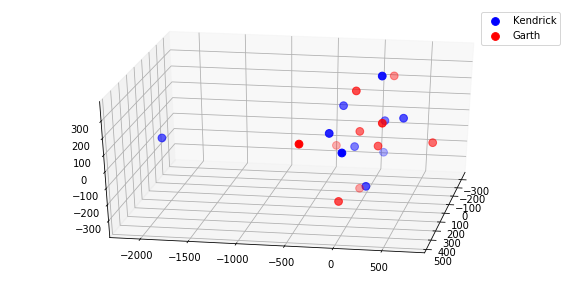

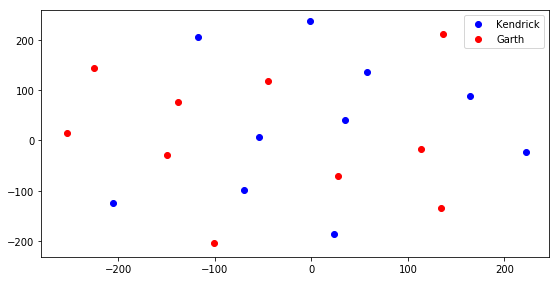

In [95]:
kendrick_3d = transformed_data_3d[:10]
k3_x = [i[0] for i in kendrick_3d]
k3_y = [i[1] for i in kendrick_3d]
k3_z = [i[2] for i in kendrick_3d]

garth_3d = transformed_data_3d[10:]
g3_x = [i[0] for i in garth_3d]
g3_y = [i[1] for i in garth_3d]
g3_z = [i[2] for i in garth_3d]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(k3_x, k3_y, k3_z, c='b', s=60, label='Kendrick')
ax.scatter(g3_x, g3_y, g3_z, c='red', s=60, label='Garth')
ax.view_init(30, 10)
ax.legend()
plt.show()

kendrick_2d = transformed_data_2d[:10]
k2_x = [i[0] for i in kendrick_2d]
k2_y = [i[1] for i in kendrick_2d]

garth_2d = transformed_data_2d[10:]
g2_x = [i[0] for i in garth_2d]
g2_y = [i[1] for i in garth_2d]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(222)
ax.scatter(k2_x, k2_y, c='b', label='Kendrick')
ax.scatter(g2_x, g2_y, c='red', label='Garth')
ax.legend()
plt.show()

Interesting! Take a crack at interpreting these graphs by answering the following question below:

What does each graph mean? Do you find one graph more informative than the other? Do you think that this method shows us discernable differences between Kendrick Lamar songs and Garth Brooks songs?  Use the graphs and your understanding of TF-IDF to support your answer.  

Write your answer to this question below this line:
________________________________________________________________________________________________________________________________

Both graphs show a basic trend among the red and blue dots, although the 3-dimensional graph is more informative than the 2-dimensional graph.  We see a separation between the two artists because they both have words that they use, but the other artist does not.  The words in each song that are common to both are reduced very small numbers or to 0, because of the log operation in the IDF function.  This means that the elements of each song vector with the highest values will be the ones that have words that are unique to that specific document, or at least are rarely used in others.  

## Summary

In this lab, we learned how to: 
* Tokenize a corpus of words and identify the different choices to be made while parsing them
* Use a Count Vectorization strategy to create a Bag of Words
* Use TF-IDF Vectorization with multiple documents to identify words that are important/unique to certain documents
* Visualize and compare vectorized text documents